In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from fredapi import Fred

In [3]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)  # 5 years

In [5]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False, progress=False)
    adj_close_df[ticker] = data['Adj Close']

In [7]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1)).dropna()

In [9]:
cov_matrix = log_returns.cov() * 252  # Annualized

In [11]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

In [13]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [15]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

In [17]:
try:
    fred = Fred(api_key='427420e2c55c00c4e9f6ec01b66205af')  # Replace with your own API key
    rate_series = fred.get_series('GS10')
    risk_free_rate = rate_series.dropna().iloc[-1] / 100
except:
    print("⚠️ Warning: Could not fetch risk-free rate from FRED. Using default 4.5%")
    risk_free_rate = 0.045

In [19]:
initial_weights = np.array([1 / len(tickers)] * len(tickers))
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(len(tickers))]

In [21]:
optimized_results = minimize(
    neg_sharpe_ratio,
    initial_weights,
    args=(log_returns, cov_matrix, risk_free_rate),
    method='SLSQP',
    constraints=constraints,
    bounds=bounds
)

In [23]:
optimal_weights = optimized_results.x

In [25]:
print("✅ Optimal Portfolio Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

✅ Optimal Portfolio Weights:
SPY: 0.5000
BND: 0.0000
GLD: 0.5000
QQQ: 0.0000
VTI: 0.0000


In [27]:
portfolio_return = expected_return(optimal_weights, log_returns)
portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
portfolio_sharpe = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"\n📈 Expected Annual Return: {portfolio_return:.4f}")
print(f"📉 Expected Volatility: {portfolio_volatility:.4f}")
print(f"💡 Sharpe Ratio: {portfolio_sharpe:.4f}")



📈 Expected Annual Return: 0.1375
📉 Expected Volatility: 0.1248
💡 Sharpe Ratio: 0.7471


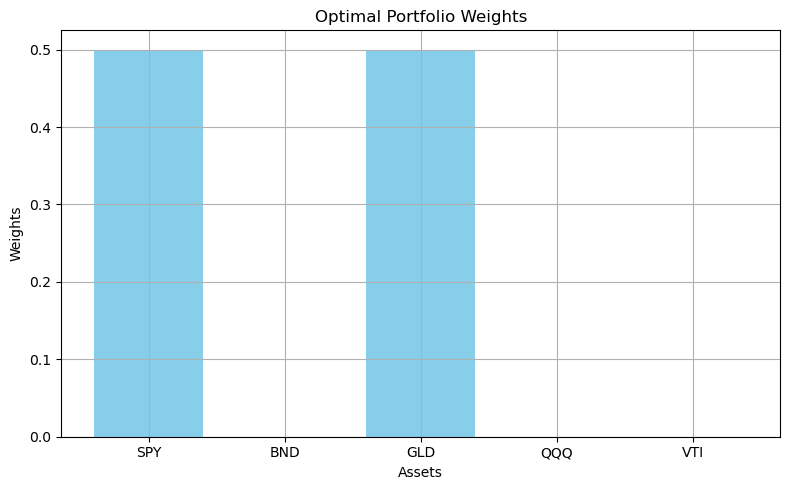

In [29]:
plt.figure(figsize=(8, 5))
plt.bar(tickers, optimal_weights, color='skyblue')
plt.title("Optimal Portfolio Weights")
plt.xlabel("Assets")
plt.ylabel("Weights")
plt.grid(True)
plt.tight_layout()
plt.show()

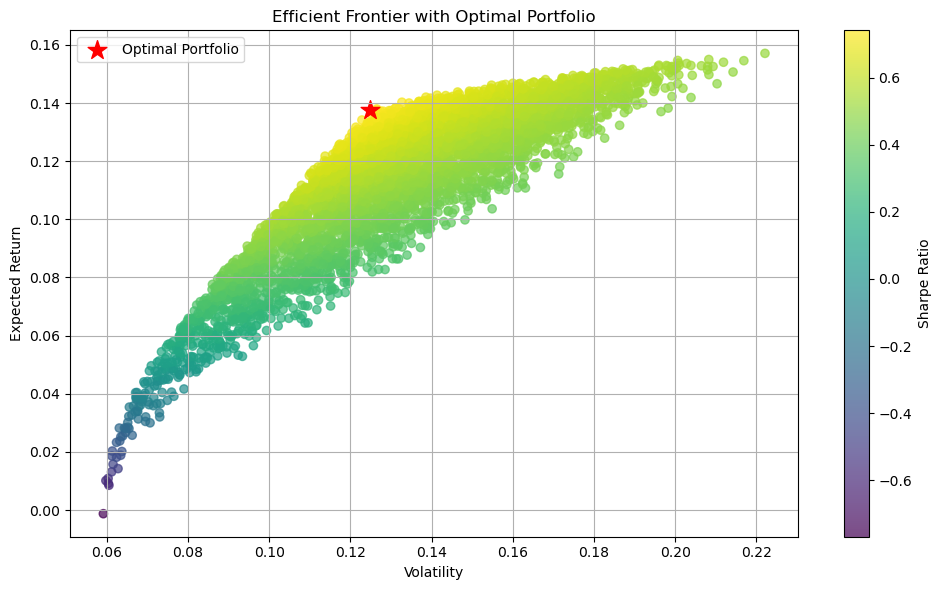

In [31]:
def simulate_portfolios(num_portfolios, log_returns, cov_matrix, risk_free_rate):
    results = {'Returns': [], 'Volatility': [], 'Sharpe': []}
    for _ in range(num_portfolios):
        weights = np.random.dirichlet(np.ones(len(tickers)))
        ret = expected_return(weights, log_returns)
        vol = standard_deviation(weights, cov_matrix)
        sharpe = (ret - risk_free_rate) / vol
        results['Returns'].append(ret)
        results['Volatility'].append(vol)
        results['Sharpe'].append(sharpe)
    return pd.DataFrame(results)

simulations = simulate_portfolios(5000, log_returns, cov_matrix, risk_free_rate)

plt.figure(figsize=(10, 6))
plt.scatter(simulations['Volatility'], simulations['Returns'], c=simulations['Sharpe'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(portfolio_volatility, portfolio_return, c='red', marker='*', s=200, label='Optimal Portfolio')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Optimal Portfolio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()